In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

train_df = pd.read_csv("data\encoded_loan_data_train.csv")
test_df = pd.read_csv("data\encoded_loan_data_test.csv")

target_col = "Default"

if "LoanID" in train_df.columns:
    train_df = train_df.drop(columns=["LoanID"])
if "LoanID" in test_df.columns:
    test_df = test_df.drop(columns=["LoanID"])

if target_col in test_df.columns:
    test_df = test_df.drop(columns=[target_col])

feature_cols = [col for col in train_df.columns if col != target_col]

X = train_df[feature_cols]
y = train_df[target_col]

mask = ~y.isna()
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.20
)

train_data = pd.concat([X_train, y_train], axis=1)

majority = train_data[train_data[target_col] == 0]
minority = train_data[train_data[target_col] == 1]

# Undersample majority
n_majority_target = math.floor(len(minority) * 2)
majority_downsampled = majority.sample(n=n_majority_target, random_state=43)

train_balanced = pd.concat([majority_downsampled, minority]).sample(frac=1, random_state=42)

X_train_balanced = train_balanced[feature_cols]
y_train_balanced = train_balanced[target_col]

print("Balanced class counts:")
print(train_balanced[target_col].value_counts())

Balanced class counts:
Default
0    45554
1    22777
Name: count, dtype: int64


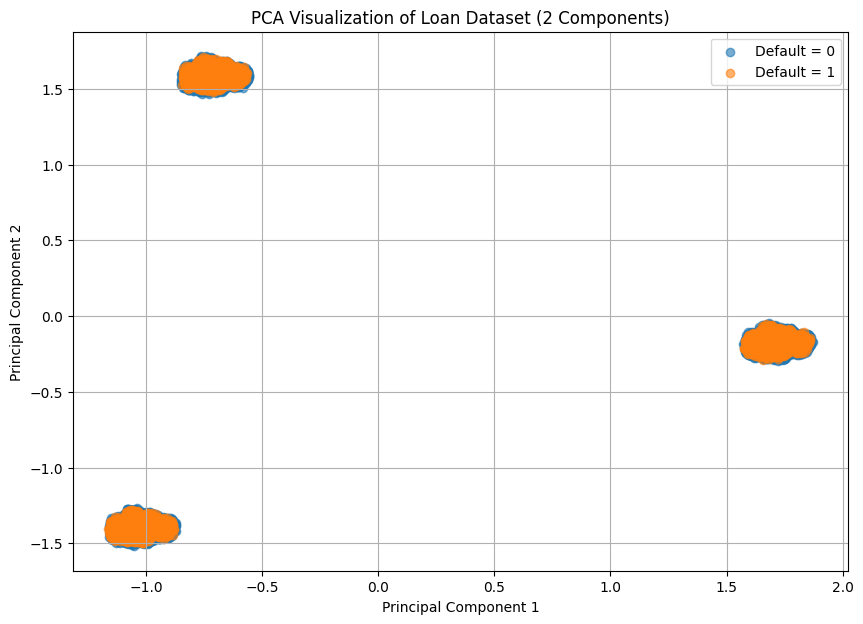

Explained variance ratio: [0.06006268 0.05997457]


In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ----------------------------------------------------
# PCA VISUALIZATION (2 COMPONENTS)
# ----------------------------------------------------

# Scale the numeric feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for easy plotting
pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Default": y.values
})

# Plot PCA
plt.figure(figsize=(10, 7))

colors = {0: "blue", 1: "red"}

for default_value in [0, 1]:
    subset = pca_df[pca_df["Default"] == default_value]
    plt.scatter(
        subset["PC1"],
        subset["PC2"],
        label=f"Default = {default_value}",
        alpha=0.6
    )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Loan Dataset (2 Components)")
plt.legend()
plt.grid(True)
plt.show()

# Explain variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

Accuracy: 0.8370287344609741


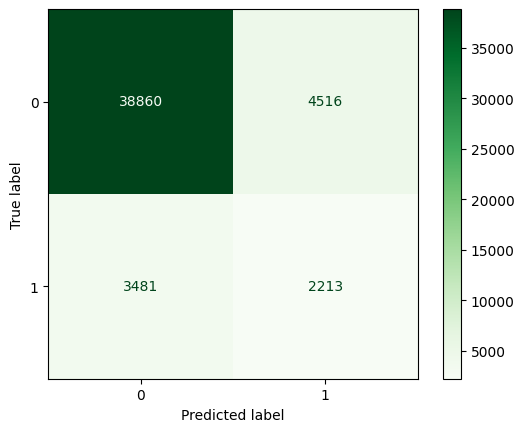


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     43376
           1       0.33      0.39      0.36      5694

    accuracy                           0.84     49070
   macro avg       0.62      0.64      0.63     49070
weighted avg       0.85      0.84      0.84     49070

ROC-AUC: 0.748794890468226

Regression Metrics (on classification predictions):
MAE: 0.16297126553902588
RMSE: 0.4036969971885175
R²: -0.5888254615670954

Random Forest Feature Importance:
                         Feature  Importance
0                            Age    0.131295
6                   InterestRate    0.130603
1                         Income    0.123469
2                     LoanAmount    0.107255
4                 MonthsEmployed    0.098143
3                    CreditScore    0.086576
8                       DTIRatio    0.077402
7                       LoanTerm    0.034464
9                      Education    0.029439
5         

In [2]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay,
    roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
)
import numpy as np

rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=30,
        min_samples_leaf=2,
        random_state=42
    ))
])

rf_pipeline.fit(X_train_balanced, y_train_balanced)

y_pred_rf = rf_pipeline.predict(X_test)

y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Greens")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


roc = roc_auc_score(y_test, y_proba_rf)
print("ROC-AUC:", roc)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)
print("\nRegression Metrics (on classification predictions):")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

importances = rf_pipeline.named_steps["rf"].feature_importances_
feature_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nRandom Forest Feature Importance:")
print(feature_importance)



Best parameters: {'rf__max_depth': 30, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 300}
Best CV F1 score: 0.4794494588067023

Test Accuracy (Tuned): 0.8370287344609741


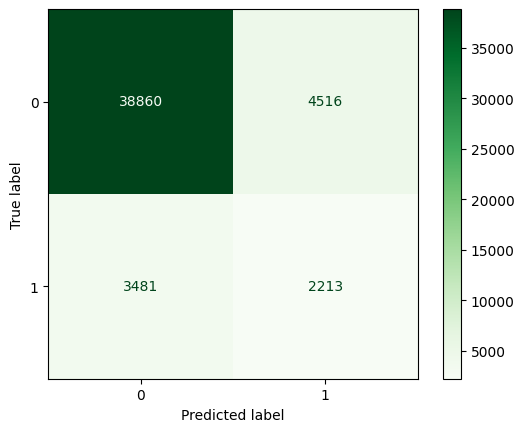


Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     43376
           1       0.33      0.39      0.36      5694

    accuracy                           0.84     49070
   macro avg       0.62      0.64      0.63     49070
weighted avg       0.85      0.84      0.84     49070



In [ ]:

param_grid_rf = {
    "rf__n_estimators": [200, 250,  300],
    "rf__max_depth": [None, 20, 30, 40, 50],
    "rf__min_samples_leaf": [1, 2, 3, 4]
}

grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid_rf,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_search_rf.fit(X_train_balanced, y_train_balanced)

print("\nBest parameters:", grid_search_rf.best_params_)
print("Best CV F1 score:", grid_search_rf.best_score_)

y_pred_rf_best = grid_search_rf.best_estimator_.predict(X_test)

print("\nTest Accuracy (Tuned):", accuracy_score(y_test, y_pred_rf_best))

cm = confusion_matrix(y_test, y_pred_rf_best, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Greens")
plt.show()

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_rf_best))
